In [1]:
# Actor-Critic for Grid-World

## 必要なライブラリをインポートします
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt



In [2]:

## 環境の設定
class GridWorld:
    def __init__(self, size=4, pitfall_positions=None):
        self.size = size
        self.state = np.zeros((size, size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        self.goal = [size-1, size-1]
        # 落とし穴の位置をリストで指定（デフォルトはなし）
        self.pitfall_positions = pitfall_positions if pitfall_positions else []

    def reset(self):
        self.state = np.zeros((self.size, self.size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        return self.state.flatten()

    def step(self, action):
        if self.done:
            raise ValueError("Game is done")
        
        if action == 0 and self.pos[1] > 0:   # Left
            self.pos[1] -= 1
        elif action == 1 and self.pos[1] < self.size - 1:  # Right
            self.pos[1] += 1
        elif action == 2 and self.pos[0] > 0:  # Up
            self.pos[0] -= 1
        elif action == 3 and self.pos[0] < self.size - 1:  # Down
            self.pos[0] += 1
        
        self.state = np.zeros((self.size, self.size))
        self.state[self.pos[0], self.pos[1]] = 1
        
        # 報酬設計
        reward = -1
        if self.pos == self.goal:
            reward = 100
            self.done = True
        elif self.pos in self.pitfall_positions:
            reward = -101  # 落とし穴に落ちた場合、大きなペナルティ
            self.done = True
        
        return self.state.flatten(), reward, self.done

## Actor-Criticモデルの定義
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_size)
        self.fc_critic = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        actor_output = F.softmax(self.fc_actor(x), dim=-1)
        critic_output = self.fc_critic(x)
        return actor_output, critic_output

## エージェントの定義
class Agent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001, epsilon=0.1):
        self.actor_critic = ActorCritic(state_size, action_size)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_size = action_size
    
    def select_action(self, state, deterministic=False):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.actor_critic(state)
        
        if deterministic:
            action = torch.argmax(probs).item()  # 最も高い確率の行動を選択
        else:
            if random.random() > self.epsilon:
                action = torch.argmax(probs).item()  # 最も高い確率の行動を選択
            else:
                action = random.choice(range(self.action_size))  # ランダムに行動を選択
            
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob

    def update(self, log_probs, values, rewards, next_value, dones):
        Qvals = np.zeros(len(rewards))
        Qval = next_value
        
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + self.gamma * Qval * (1 - dones[t])
            Qvals[t] = Qval
        
        Qvals = torch.tensor(Qvals)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        
        actor_loss = (-log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()




# 落とし穴なし

In [3]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
pitfall_positions = [[1, 1], [2, 2]]
# env = GridWorld(size=4, pitfall_positions=pitfall_positions)
env = GridWorld(size=4, pitfall_positions=None)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 1000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    
    # エージェントの更新
    Qval = np.zeros(len(rewards))
    Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
    
    for t in reversed(range(len(rewards)-1)):
        Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
    
    Q_values.append(Qval.mean().item())
    
    Qval = torch.tensor(Qval)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


Episode 100/1000, Average Score: -46.19
Episode 200/1000, Average Score: -11.85
Episode 300/1000, Average Score: -24.57
Episode 400/1000, Average Score: -21.03
Episode 500/1000, Average Score: -10.86
Episode 600/1000, Average Score: -8.63
Episode 700/1000, Average Score: 10.27
Episode 800/1000, Average Score: -9.11
Episode 900/1000, Average Score: 33.85
Episode 1000/1000, Average Score: 33.38


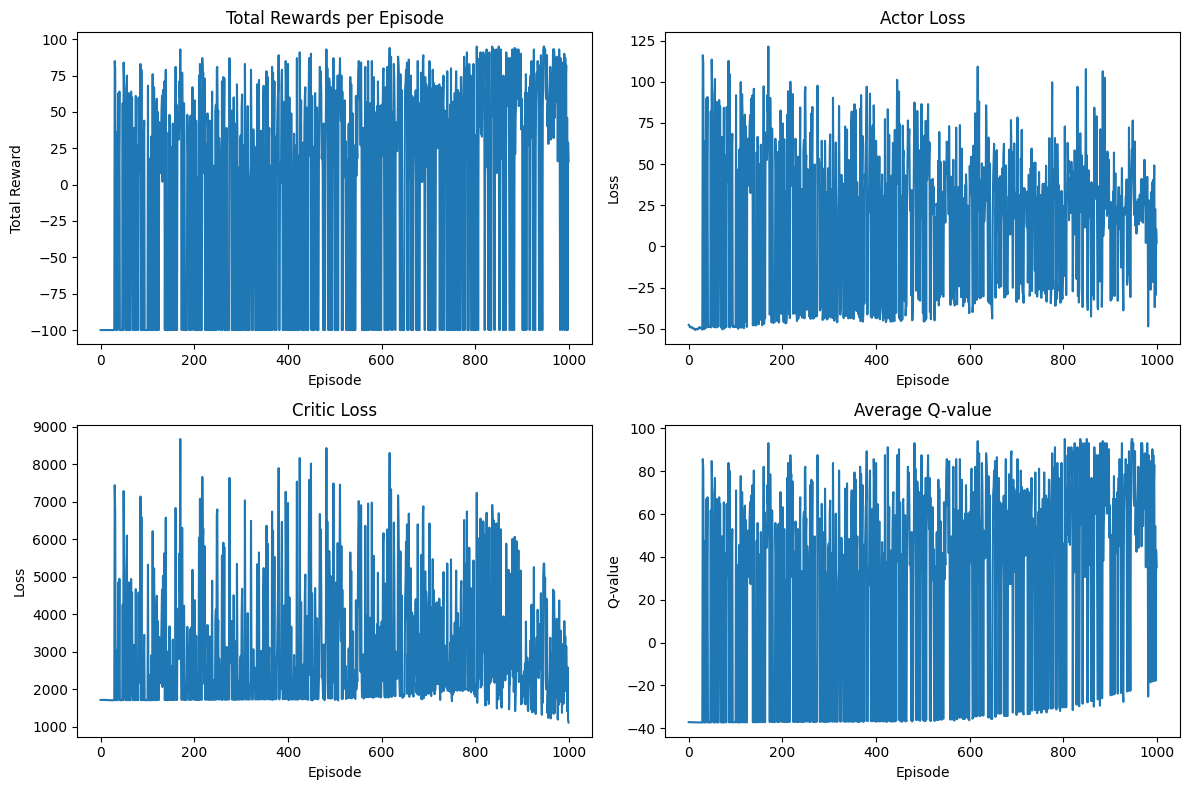

In [4]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


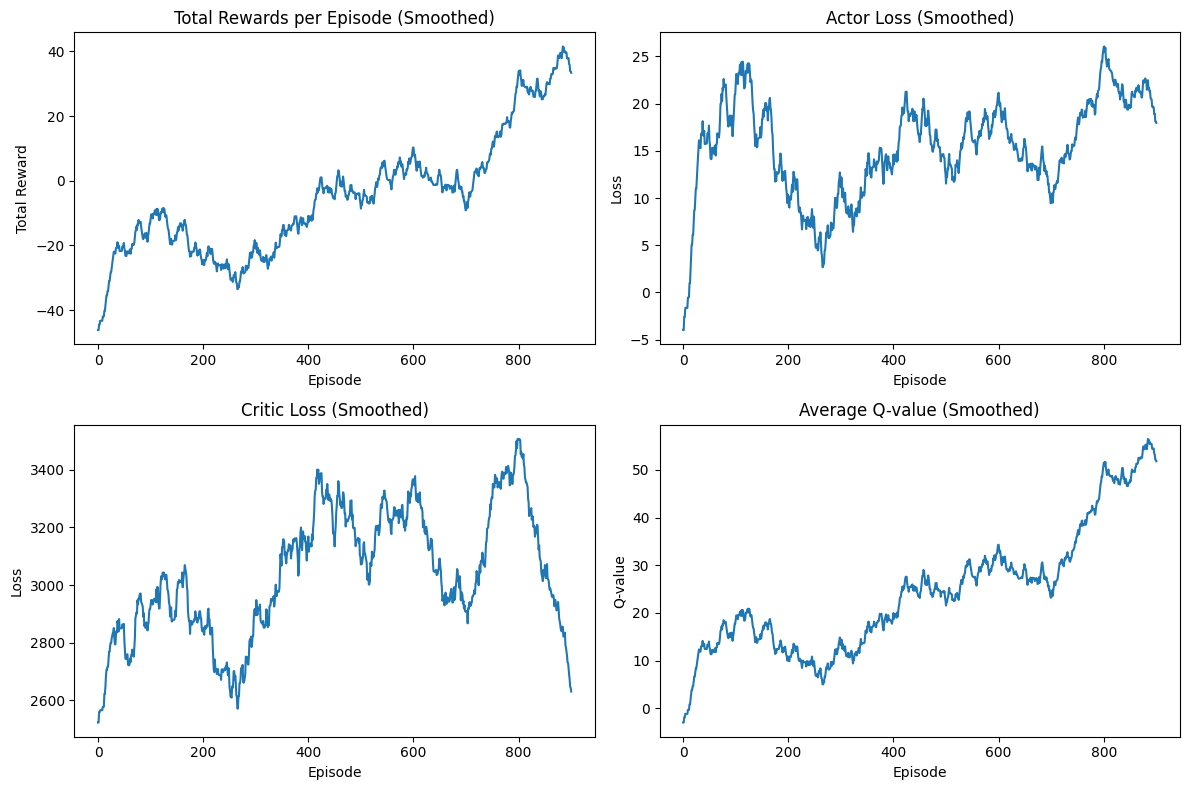

In [5]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 100

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [6]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


[['v' '>' 'v' 'v']
 ['>' 'v' 'v' '>']
 ['>' '>' '>' '<']
 ['v' 'v' '>' 'G']]


In [8]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)


[['S' '-' '-' '-']
 ['o' 'o' 'o' '-']
 ['-' 'o' 'o' 'o']
 ['-' '-' 'o' 'G']]


# 落とし穴あり

In [9]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
pitfall_positions = [[2, 2]] # 落とし穴の位置を指定
# pitfall_positions = [[1,1],[2,2]]  # 落とし穴を2つ設置するとうまく学習できない
env = GridWorld(size=4, pitfall_positions=pitfall_positions)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 5000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    
    # エージェントの更新
    Qval = np.zeros(len(rewards))
    Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
    
    for t in reversed(range(len(rewards)-1)):
        Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
    
    Q_values.append(Qval.mean().item())
    
    Qval = torch.tensor(Qval)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


Episode 100/5000, Average Score: 9.02
Episode 200/5000, Average Score: -17.31
Episode 300/5000, Average Score: -12.52
Episode 400/5000, Average Score: -9.78
Episode 500/5000, Average Score: -9.07
Episode 600/5000, Average Score: 5.87
Episode 700/5000, Average Score: 13.01
Episode 800/5000, Average Score: 18.95
Episode 900/5000, Average Score: 35.32
Episode 1000/5000, Average Score: 34.81
Episode 1100/5000, Average Score: 48.57
Episode 1200/5000, Average Score: 55.47
Episode 1300/5000, Average Score: 52.88
Episode 1400/5000, Average Score: 40.14
Episode 1500/5000, Average Score: 80.43
Episode 1600/5000, Average Score: 75.71
Episode 1700/5000, Average Score: 71.14
Episode 1800/5000, Average Score: 75.12
Episode 1900/5000, Average Score: 74.47
Episode 2000/5000, Average Score: 87.53
Episode 2100/5000, Average Score: 88.5
Episode 2200/5000, Average Score: 94.68
Episode 2300/5000, Average Score: 76.84
Episode 2400/5000, Average Score: 86.43
Episode 2500/5000, Average Score: 82.72
Episode 26

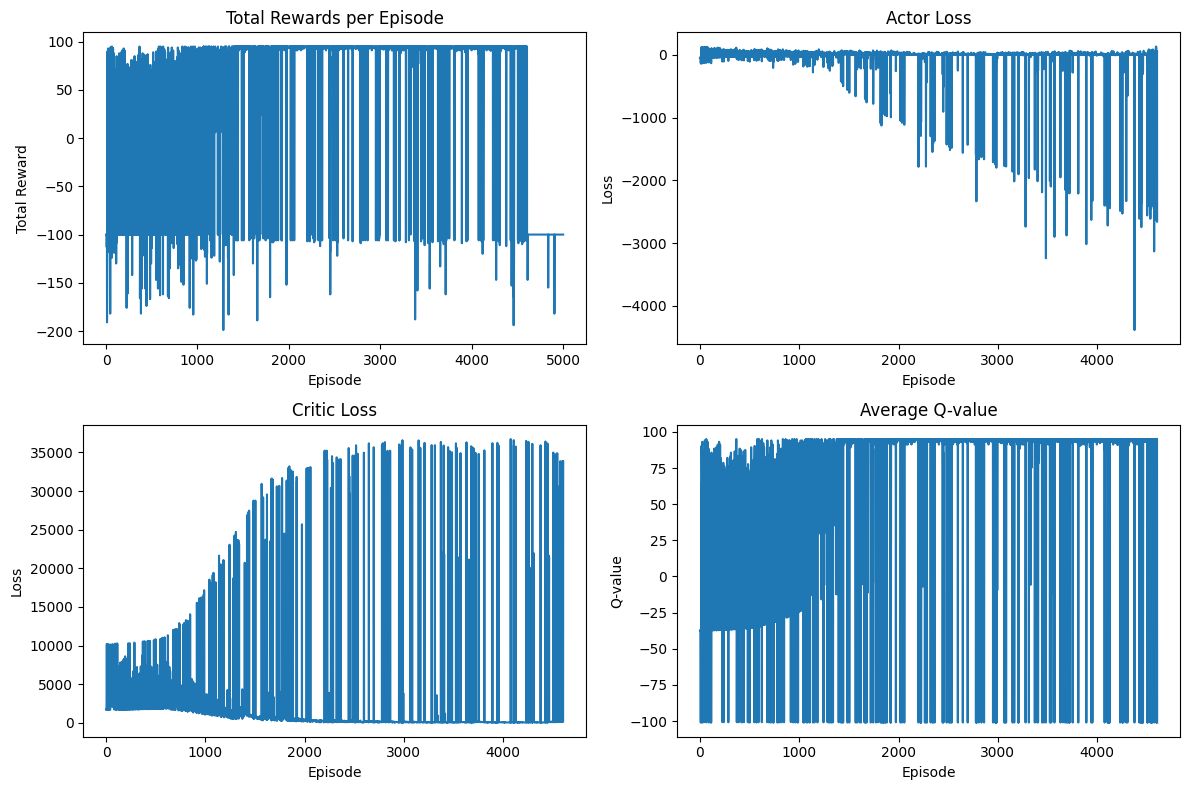

In [10]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


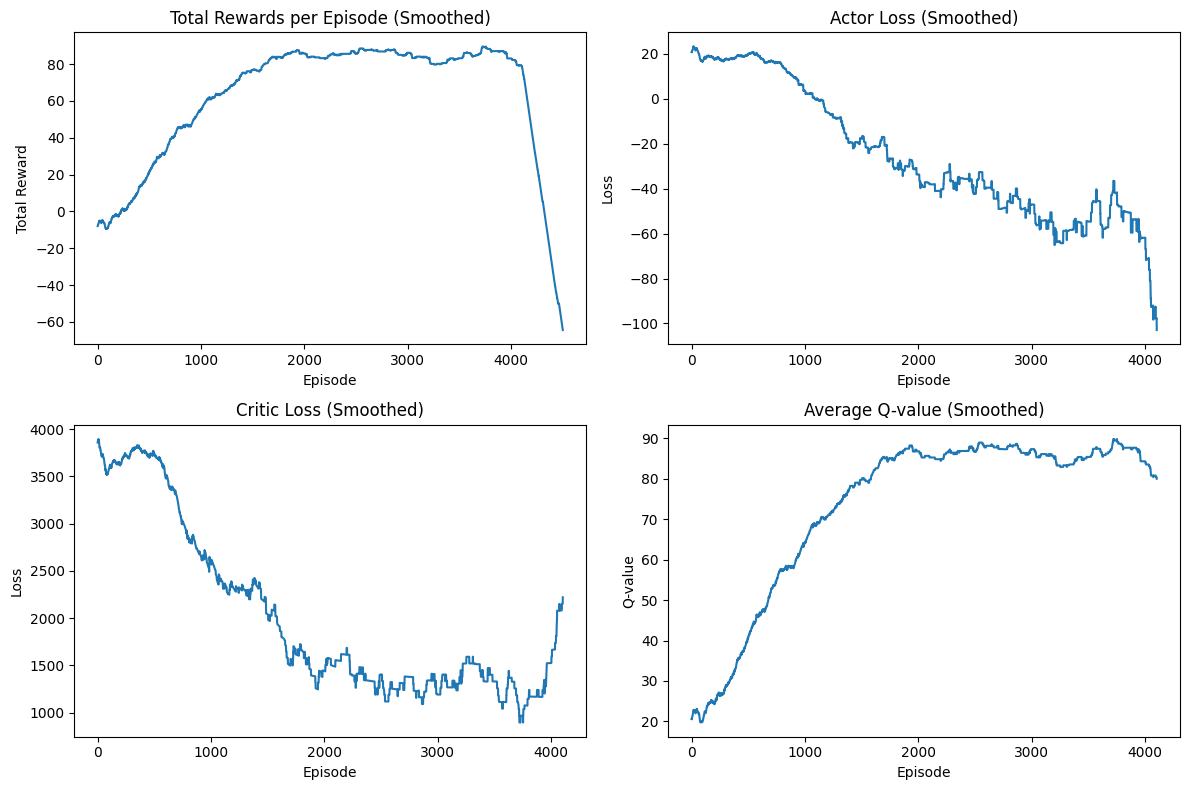

In [11]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 500

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [12]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


[['<' '<' '<' '<']
 ['<' '<' '<' '<']
 ['<' '<' 'X' '<']
 ['<' '<' '<' 'G']]


In [13]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)


[['S' 'o' '-' '-']
 ['o' 'o' '-' '-']
 ['o' 'o' 'X' '-']
 ['o' 'o' 'o' 'G']]


# 落とし穴2つ

In [14]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
# pitfall_positions = [[2, 2]] # 落とし穴の位置を指定
pitfall_positions = [[1,1],[2,2]]  # 落とし穴を2つ設置するとうまく学習できない
env = GridWorld(size=4, pitfall_positions=pitfall_positions)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 2000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    
    # エージェントの更新
    Qval = np.zeros(len(rewards))
    Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
    
    for t in reversed(range(len(rewards)-1)):
        Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
    
    Q_values.append(Qval.mean().item())
    
    Qval = torch.tensor(Qval)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


Episode 100/2000, Average Score: -120.97
Episode 200/2000, Average Score: -91.59
Episode 300/2000, Average Score: 82.4
Episode 400/2000, Average Score: 74.52
Episode 500/2000, Average Score: 72.65
Episode 600/2000, Average Score: 74.64
Episode 700/2000, Average Score: 72.73
Episode 800/2000, Average Score: 82.44
Episode 900/2000, Average Score: 72.44
Episode 1000/2000, Average Score: 72.72
Episode 1100/2000, Average Score: 76.82
Episode 1200/2000, Average Score: 78.48
Episode 1300/2000, Average Score: 74.72
Episode 1400/2000, Average Score: 82.41
Episode 1500/2000, Average Score: 80.56
Episode 1600/2000, Average Score: 72.96
Episode 1700/2000, Average Score: 84.36
Episode 1800/2000, Average Score: 73.39
Episode 1900/2000, Average Score: 92.57
Episode 2000/2000, Average Score: 79.81


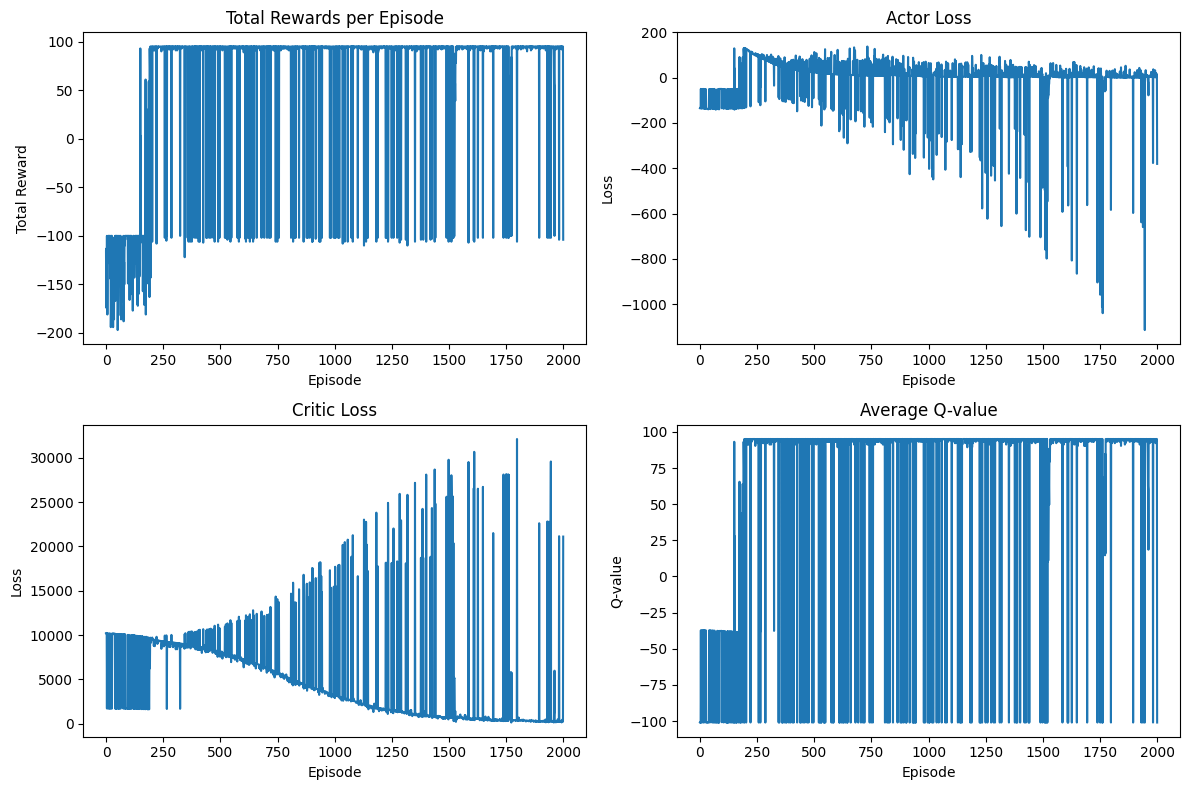

In [15]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


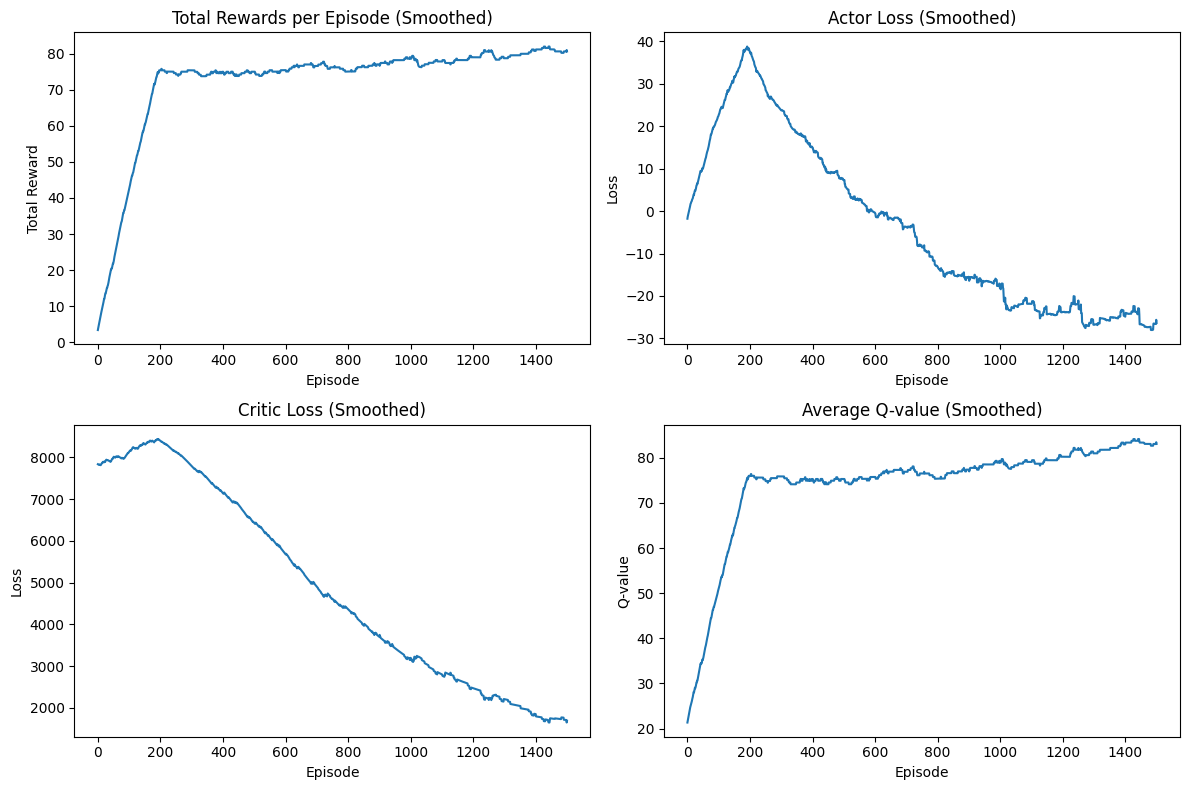

In [16]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 500

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [17]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


[['v' '>' 'v' 'v']
 ['v' 'X' 'v' 'v']
 ['v' 'v' 'X' 'v']
 ['>' '>' '>' 'G']]


In [18]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)


[['S' '-' '-' '-']
 ['o' 'X' '-' '-']
 ['o' '-' 'X' '-']
 ['o' 'o' 'o' 'G']]
